In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Import data
def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns * weights) * Time
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)
    return returns, std

# List of Indian stocks (NSE)
stockList = [
    'RELIANCE', 'TCS', 'INFY', 'HDFCBANK', 'ICICIBANK', 'SBIN', 'KOTAKBANK', 
    'LT', 'ITC', 'BHARTIARTL', 'ASIANPAINT', 'HCLTECH', 'AXISBANK', 'MARUTI', 'BAJFINANCE', 
    'HINDUNILVR', 'TITAN', 'ULTRACEMCO', 'WIPRO', 'NESTLEIND', 'SUNPHARMA', 'POWERGRID', 
    'NTPC', 'BAJAJFINSV', 'M&M', 'TECHM', 'INDUSINDBK', 'JSWSTEEL', 'TATASTEEL', 
    'ADANIPORTS', 'GRASIM', 'CIPLA', 'ONGC', 'SBILIFE', 'BPCL', 'DIVISLAB', 'HEROMOTOCO', 
    'DRREDDY', 'BRITANNIA', 'COALINDIA', 'EICHERMOT', 'APOLLOHOSP', 'HINDALCO', 'TATAMOTORS', 
    'ICICIPRULI', 'UPL', 'ADANIENT', 'DLF', 'BAJAJ-AUTO'
]

stocks = [stock + '.NS' for stock in stockList]  # Use '.NS' for NSE stocks
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
if returns is not None:
    returns = returns.dropna()

    weights = np.random.random(len(returns.columns))
    weights /= np.sum(weights)

    returns['portfolio'] = returns.dot(weights)
else:
    print("Data retrieval failed. Check the error message above.")

[*********************100%%**********************]  49 of 49 completed


In [5]:
# Monte Carlo Method with TensorFlow
mc_sims = 100  # number of simulations
T = 252  # timeframe in days

# Convert meanReturns and covMatrix to TensorFlow tensors directly
meanReturns = tf.constant(meanReturns, dtype=tf.float32)  # No need for .values
covMatrix = tf.constant(covMatrix, dtype=tf.float32)
weights = tf.constant(weights, dtype=tf.float32)
weights = tf.reshape(weights, (-1, 1))  # Reshape weights to be a column vector
initialPortfolio = 10000

chol_decomp = tf.linalg.cholesky(covMatrix)

# Prepare for simulation
@tf.function
def run_monte_carlo_sim():
    portfolio_sims = tf.TensorArray(tf.float32, size=mc_sims)

    for m in tf.range(mc_sims):
        Z = tf.random.normal(shape=(T, len(weights)), dtype=tf.float32)
        daily_returns = tf.linalg.matmul(chol_decomp, Z, transpose_b=True)
        # Expand meanReturns to match daily_returns shape (49, 252)
        daily_returns = meanReturns[:, tf.newaxis] + daily_returns
        # Transpose daily_returns to be (252, 49) before multiplying with weights
        daily_returns = tf.transpose(daily_returns)
        cumulative_returns = tf.math.cumprod(tf.matmul(daily_returns, weights) + 1, axis=0)
        portfolio_value = cumulative_returns * initialPortfolio
        portfolio_sims = portfolio_sims.write(m, portfolio_value)
    
    return portfolio_sims.stack()

# Run the simulation
portfolio_sims = run_monte_carlo_sim()

# Calculate quantity per stock based on the first day price (ensure 49 stocks)
quantities = initialPortfolio / returns.iloc[0]  # This should return 49 values, one for each stock

# Create an empty list to store the portfolio details (weights * quantity and final portfolio value)
portfolio_details = []

for i in range(mc_sims):
    # Get the final portfolio value for each simulation and convert it to a scalar
    final_portfolio_value = portfolio_sims[i, -1].numpy().squeeze()  # Ensure this is a scalar

    # Ensure the multiplication happens between arrays of the same shape (49,)
    weighted_quantities = weights.numpy().flatten() * quantities[:49]  # Take only the first 49 elements of quantities
    
    # Append weighted quantities and the final portfolio value to the details
    portfolio_details.append(np.concatenate((weighted_quantities, [final_portfolio_value])))
    
# Convert to DataFrame for easy saving to Excel
columns = [f"{stock} (Weight*Qty)" for stock in stockList] + ["Final Portfolio Value"]
df = pd.DataFrame(portfolio_details, columns=columns)

# Save the DataFrame to Excel
output_file = 'monte_carlo_simulation_results.xlsx'  # Saves the file in the current directory
df.to_excel(output_file, index_label="Simulation No.")

print(f"Portfolio simulation results saved to {output_file}")


Portfolio simulation results saved to monte_carlo_simulation_results.xlsx


In [3]:
# Monte Carlo Method with TensorFlow
mc_sims = 100  # number of simulations
T = 252  # timeframe in days

# Convert meanReturns and covMatrix to TensorFlow tensors directly
meanReturns = tf.constant(meanReturns, dtype=tf.float32)  # No need for .values
covMatrix = tf.constant(covMatrix, dtype=tf.float32)
weights = tf.constant(weights, dtype=tf.float32)
weights = tf.reshape(weights, (-1, 1))  # Reshape weights to be a column vector
initialPortfolio = 10000

chol_decomp = tf.linalg.cholesky(covMatrix)

# Prepare for simulation
@tf.function
def run_monte_carlo_sim():
    portfolio_sims = tf.TensorArray(tf.float32, size=mc_sims)

    for m in tf.range(mc_sims):
        Z = tf.random.normal(shape=(T, len(weights)), dtype=tf.float32)
        daily_returns = tf.linalg.matmul(chol_decomp, Z, transpose_b=True)
        # Expand meanReturns to match daily_returns shape (49, 252)
        daily_returns = meanReturns[:, tf.newaxis] + daily_returns
        # Transpose daily_returns to be (252, 49) before multiplying with weights
        daily_returns = tf.transpose(daily_returns)
        cumulative_returns = tf.math.cumprod(tf.matmul(daily_returns, weights) + 1, axis=0)
        portfolio_value = cumulative_returns * initialPortfolio
        portfolio_sims = portfolio_sims.write(m, portfolio_value)
    
    return portfolio_sims.stack()

# Run the simulation
portfolio_sims = run_monte_carlo_sim()

C:\Users\abhis\AppData\Local\Temp\ipykernel_15352\2624996656.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


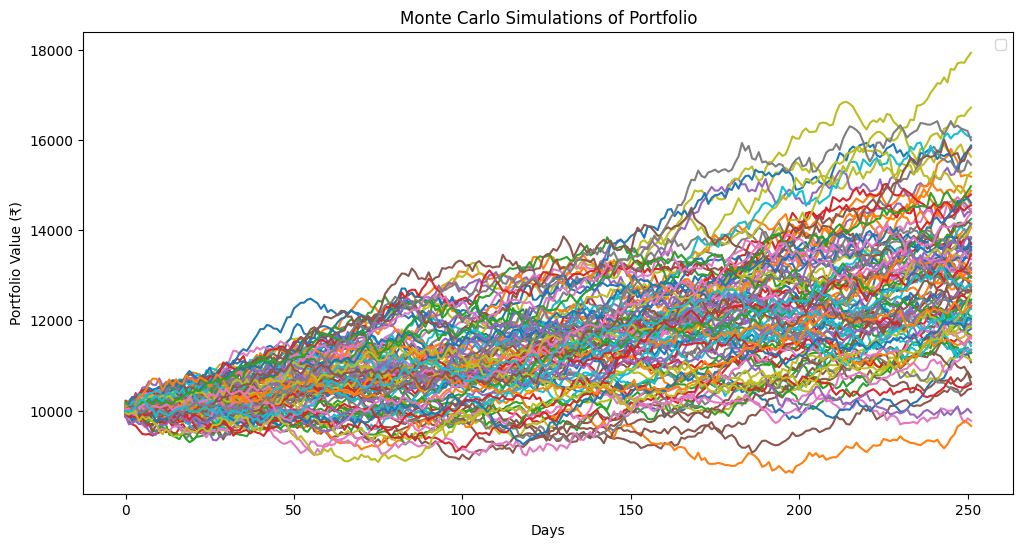

In [4]:
plt.figure(figsize=(12, 6))
for i in range(100):  # Plot first 10 simulations
    plt.plot(portfolio_sims[i, :, 0].numpy())
plt.ylabel('Portfolio Value (₹)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulations of Portfolio') 
plt.legend()
plt.show()


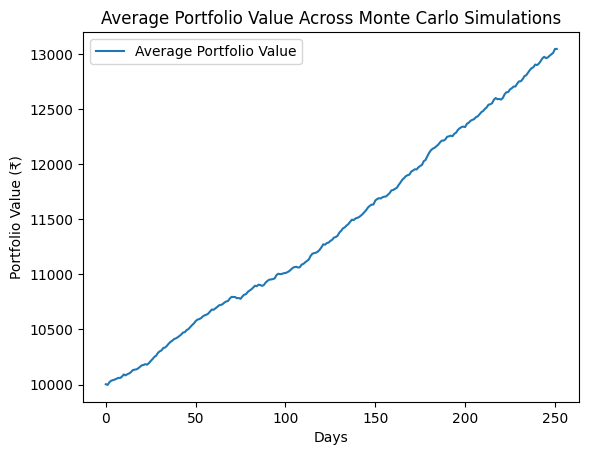

In [5]:
# Calculate mean portfolio value over all simulations for each day
mean_portfolio_value = tf.reduce_mean(portfolio_sims, axis=0)

# Plot the average portfolio value over time
plt.plot(mean_portfolio_value[:, 0].numpy(), label='Average Portfolio Value')
plt.ylabel('Portfolio Value (₹)')
plt.xlabel('Days')
plt.title('Average Portfolio Value Across Monte Carlo Simulations')
plt.legend()
plt.show()

In [6]:
# Define the function to generate antithetic pairs
def generate_antithetic_pairs(returns, chol_decomp, weights, initial_portfolio, mc_sims, T):
    antithetic_sims = tf.TensorArray(tf.float32, size=mc_sims)

    for m in tf.range(mc_sims):
        Z = tf.random.normal(shape=(T, len(weights)), dtype=tf.float32)
        Z_antithetic = -Z  # Antithetic pair is the negative of Z

        # Generate the regular and antithetic variates for daily returns
        daily_returns = tf.linalg.matmul(chol_decomp, Z, transpose_b=True)
        daily_returns_antithetic = tf.linalg.matmul(chol_decomp, Z_antithetic, transpose_b=True)
        
        # Add mean returns to both sets
        daily_returns = meanReturns[:, tf.newaxis] + daily_returns
        daily_returns_antithetic = meanReturns[:, tf.newaxis] + daily_returns_antithetic
        
        # Compute cumulative returns for both regular and antithetic simulations
        cumulative_returns = tf.math.cumprod(tf.matmul(tf.transpose(daily_returns), weights) + 1, axis=0)
        cumulative_returns_antithetic = tf.math.cumprod(tf.matmul(tf.transpose(daily_returns_antithetic), weights) + 1, axis=0)
        
        # Calculate portfolio values
        portfolio_value = cumulative_returns * initial_portfolio
        portfolio_value_antithetic = cumulative_returns_antithetic * initial_portfolio
        
        # Store the average of regular and antithetic simulations
        portfolio_avg = (portfolio_value + portfolio_value_antithetic) / 2.0
        antithetic_sims = antithetic_sims.write(m, portfolio_avg)
    
    return antithetic_sims.stack()

# Generate Antithetic Variates
antithetic_sims = generate_antithetic_pairs(returns, chol_decomp, weights, initialPortfolio, mc_sims, T)

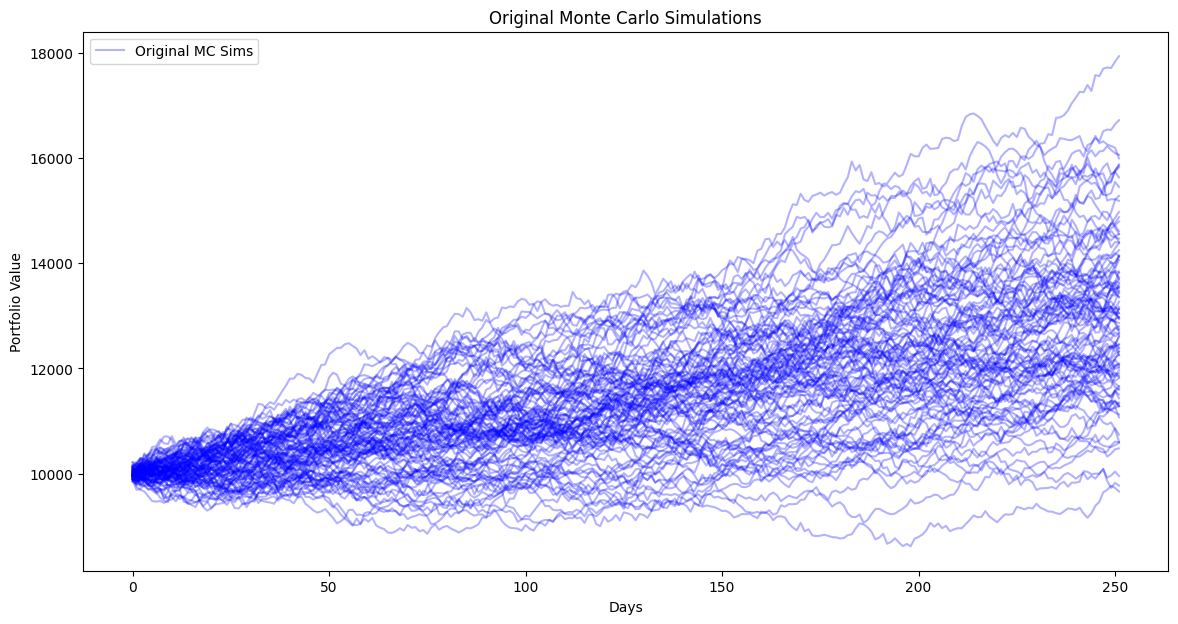

In [7]:
# Step 1: Plot some original Monte Carlo simulations
plt.figure(figsize=(14, 7))
for i in range(100):  # Plot first 400 simulations
    plt.plot(portfolio_sims[i, :, 0].numpy(), color='blue', alpha=0.3, label='Original MC Sims' if i == 0 else "")
plt.title("Original Monte Carlo Simulations")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend(loc='upper left')
plt.show()

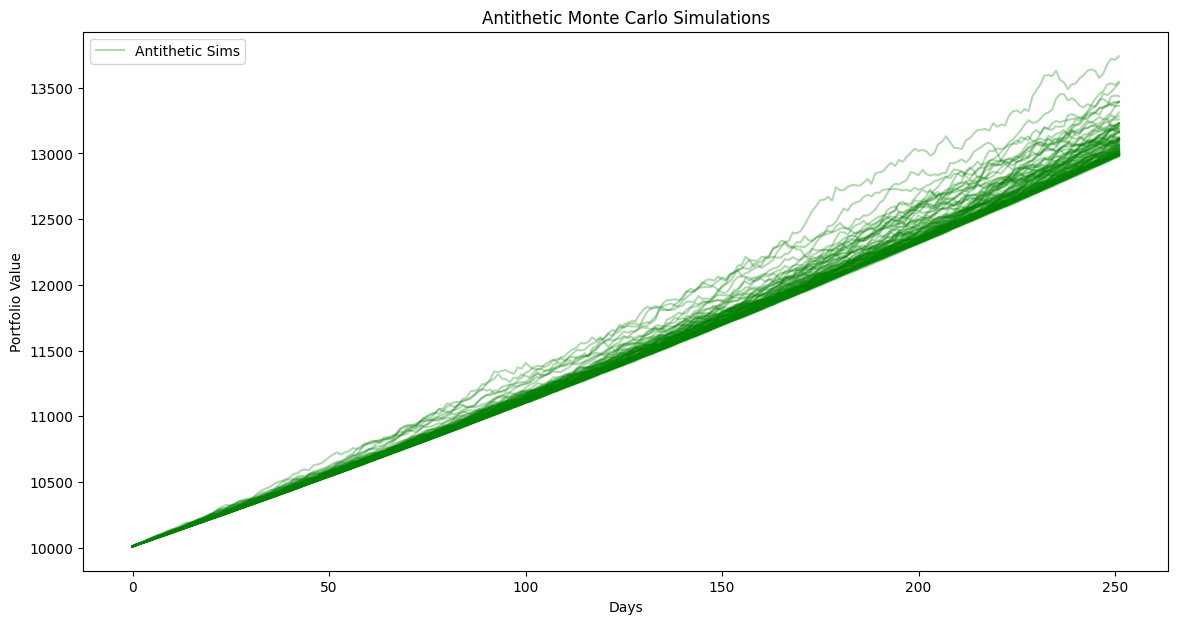

In [8]:
# Step 2: Plot the antithetic simulations
plt.figure(figsize=(14, 7))
for i in range(100):  # Plot first 400 antithetic simulations
    plt.plot(antithetic_sims[i, :, 0].numpy(), color='green', alpha=0.3, label='Antithetic Sims' if i == 0 else "")
plt.title("Antithetic Monte Carlo Simulations")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend(loc='upper left')
plt.show()

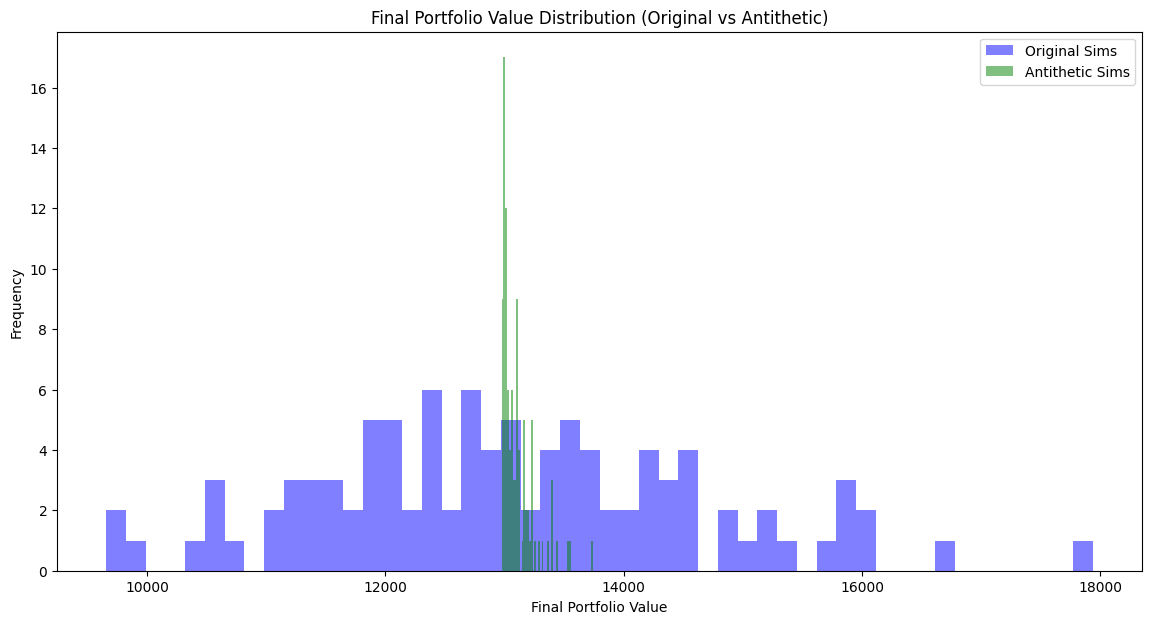

In [9]:
# Step 3: Plot the comparison of original vs antithetic variance reduction
regular_final_values = portfolio_sims[:, -1, 0].numpy()  # Final portfolio values from original MC sims
antithetic_final_values = antithetic_sims[:, -1, 0].numpy()  # Final portfolio values from antithetic sims

plt.figure(figsize=(14, 7))
plt.hist(regular_final_values, bins=50, alpha=0.5, color='blue', label='Original Sims')
plt.hist(antithetic_final_values, bins=50, alpha=0.5, color='green', label='Antithetic Sims')
plt.title('Final Portfolio Value Distribution (Original vs Antithetic)')
plt.xlabel('Final Portfolio Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [10]:
# Step 4: Calculate and print the variance of the final portfolio values
original_variance = np.var(regular_final_values)
antithetic_variance = np.var(antithetic_final_values)

print(f"Variance of Final Portfolio Values (Original Sims): {original_variance:.2f}")
print(f"Variance of Final Portfolio Values (Antithetic Sims): {antithetic_variance:.2f}")

Variance of Final Portfolio Values (Original Sims): 2514432.25
Variance of Final Portfolio Values (Antithetic Sims): 19353.29


In [11]:
# Antithetic Monte Carlo Method with TensorFlow
mc_sims = 100  # number of simulations
T = 252  # timeframe in days

# Convert meanReturns and covMatrix to TensorFlow tensors directly
meanReturns = tf.constant(meanReturns, dtype=tf.float32)  
covMatrix = tf.constant(covMatrix, dtype=tf.float32)
weights = tf.constant(weights, dtype=tf.float32)
weights = tf.reshape(weights, (-1, 1))  # Reshape weights to be a column vector
initialPortfolio = 10000

chol_decomp = tf.linalg.cholesky(covMatrix)

@tf.function
def run_antithetic_monte_carlo_sim():
    portfolio_sims = tf.TensorArray(tf.float32, size=mc_sims * 2)  # Double size for antithetic pairs

    for m in tf.range(mc_sims):
        # Generate random Z and its antithetic pair -Z
        Z = tf.random.normal(shape=(T, len(weights)), dtype=tf.float32)
        Z_antithetic = -Z
        
        # Calculate daily returns for both Z and -Z
        daily_returns = tf.linalg.matmul(chol_decomp, Z, transpose_b=True)
        daily_returns_antithetic = tf.linalg.matmul(chol_decomp, Z_antithetic, transpose_b=True)
        
        # Expand meanReturns to match daily_returns shape
        daily_returns = meanReturns[:, tf.newaxis] + daily_returns
        daily_returns_antithetic = meanReturns[:, tf.newaxis] + daily_returns_antithetic
        
        # Transpose daily_returns to be (252, 49) before multiplying with weights
        daily_returns = tf.transpose(daily_returns)
        daily_returns_antithetic = tf.transpose(daily_returns_antithetic)
        
        # Compute cumulative portfolio returns for both simulations
        cumulative_returns = tf.math.cumprod(tf.matmul(daily_returns, weights) + 1, axis=0)
        cumulative_returns_antithetic = tf.math.cumprod(tf.matmul(daily_returns_antithetic, weights) + 1, axis=0)
        
        # Calculate portfolio value over time
        portfolio_value = cumulative_returns * initialPortfolio
        portfolio_value_antithetic = cumulative_returns_antithetic * initialPortfolio
        
        # Write both original and antithetic values to the simulation result
        portfolio_sims = portfolio_sims.write(m, portfolio_value)
        portfolio_sims = portfolio_sims.write(mc_sims + m, portfolio_value_antithetic)
    
    return portfolio_sims.stack()

# Run the antithetic simulation
portfolio_sims = run_antithetic_monte_carlo_sim()


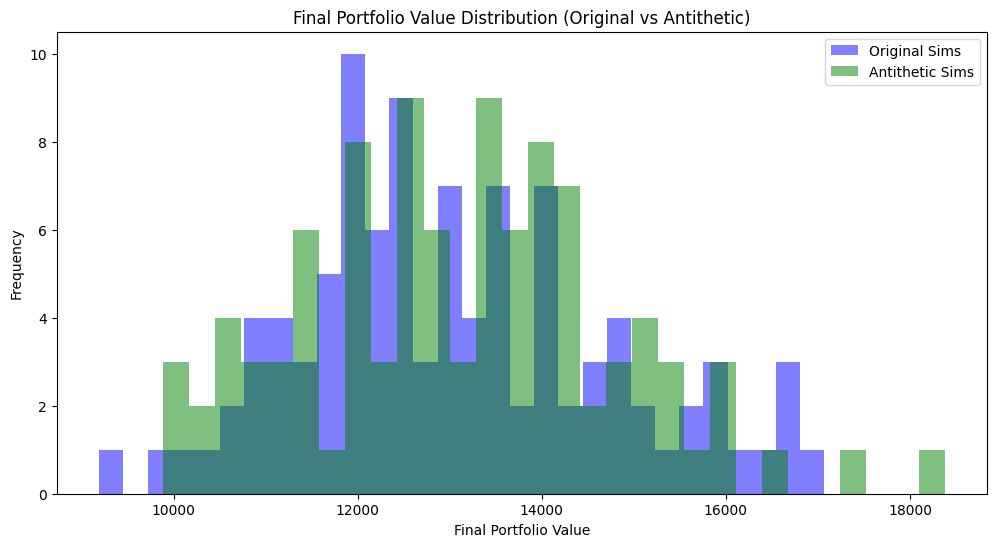

Variance of Final Portfolio Values (Original Sims): 2795703.00
Variance of Final Portfolio Values (Antithetic Sims): 2790305.50


In [12]:
import matplotlib.pyplot as plt

# Convert TensorFlow output to NumPy for easy manipulation
portfolio_sims_np = portfolio_sims.numpy()

# Extract final portfolio values (for both original and antithetic pairs)
final_portfolio_values = portfolio_sims_np[:, -1]  # Values at the last timestep

# Separate original sims from antithetic sims
original_sims = final_portfolio_values[:mc_sims]
antithetic_sims = final_portfolio_values[mc_sims:]

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(original_sims, bins=30, alpha=0.5, label='Original Sims', color='blue')
plt.hist(antithetic_sims, bins=30, alpha=0.5, label='Antithetic Sims', color='green')
plt.title('Final Portfolio Value Distribution (Original vs Antithetic)')
plt.xlabel('Final Portfolio Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print variance comparison
print(f"Variance of Final Portfolio Values (Original Sims): {np.var(original_sims):.2f}")
print(f"Variance of Final Portfolio Values (Antithetic Sims): {np.var(antithetic_sims):.2f}")


In [13]:
import numpy as np
from scipy.optimize import minimize

# Function to calculate portfolio performance (returns and risk)
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, risk

# Objective function: we aim to maximize return while minimizing risk (mean-variance optimization)
def objective_function(weights, mean_returns, cov_matrix, risk_free_rate=0):
    returns, risk = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (returns - risk_free_rate) / risk  # Risk-adjusted return (Sharpe Ratio)
    return -sharpe_ratio  # Minimize the negative Sharpe ratio for maximization

# Constraint: sum of weights should be 1 (i.e., fully invested portfolio)
def weight_constraint(weights):
    return np.sum(weights) - 1

# Bounds: weights should be between 0 and 1
bounds = [(0, 1) for _ in range(len(weights))]

# Initial guess: start with equal weight for each stock
initial_weights = np.array([1/len(weights)] * len(weights))

# Run the optimization using the antithetic simulation results
optimized_weights = minimize(
    objective_function, 
    initial_weights, 
    args=(meanReturns, covMatrix), 
    method='SLSQP', 
    bounds=bounds, 
    constraints={'type': 'eq', 'fun': weight_constraint}
)

# Extract optimized weights
optimal_weights = optimized_weights.x
print("Optimized Weights:", optimal_weights)


Optimized Weights: [6.88885102e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.71239468e-02 2.17308534e-01 7.75515630e-17 0.00000000e+00
 1.61926228e-01 1.71758384e-02 1.06812001e-01 3.75647385e-02
 1.48851093e-02 0.00000000e+00 5.45679209e-17 2.99648464e-18
 5.82722710e-17 3.00259383e-17 7.75926181e-02 2.10843154e-17
 0.00000000e+00 6.20423898e-17 2.95769446e-17 3.16255412e-03
 3.68921598e-17 2.67988162e-17 4.27766004e-17 2.67527993e-02
 1.02544807e-17 2.98314028e-17 0.00000000e+00 3.15657775e-02
 0.00000000e+00 0.00000000e+00 8.92350436e-02 2.43277608e-17
 0.00000000e+00 9.64682434e-17 0.00000000e+00 0.00000000e+00
 1.98894811e-01 0.00000000e+00 0.00000000e+00 8.21382488e-18
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.46363045e-16
 0.00000000e+00]


Original Portfolio Return: 0.0017026572581139545, Risk: 0.007165575096747358
Antithetic Portfolio Return: 0.0017026572581139545, Risk: 0.007165575096747358


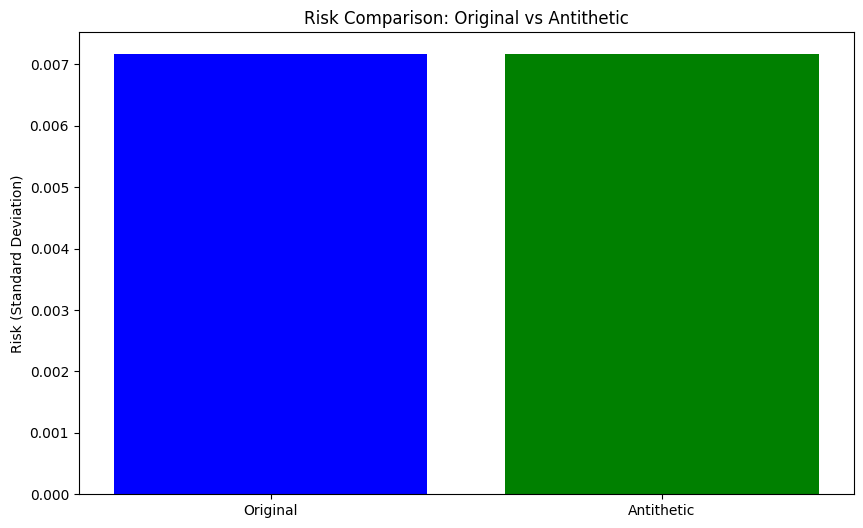

In [14]:
# Portfolio performance for original simulations
original_returns, original_risks = portfolio_performance(optimal_weights, meanReturns, covMatrix)
print(f"Original Portfolio Return: {original_returns}, Risk: {original_risks}")

# Portfolio performance for antithetic simulations
antithetic_returns, antithetic_risks = portfolio_performance(optimal_weights, meanReturns, covMatrix)
print(f"Antithetic Portfolio Return: {antithetic_returns}, Risk: {antithetic_risks}")

# Plot the final comparison
plt.figure(figsize=(10, 6))
plt.bar(['Original', 'Antithetic'], [original_risks, antithetic_risks], color=['blue', 'green'])
plt.title('Risk Comparison: Original vs Antithetic')
plt.ylabel('Risk (Standard Deviation)')
plt.show()


### more volatile stocks 

In [26]:
# Update the stock list to include only highly volatile stocks
volatile_stockList = [
    'TATAMOTORS.NS', 'ADANIENT.NS', 'ADANIPORTS.NS', 'HEROMOTOCO.NS', 
    'HINDALCO.NS', 'TATASTEEL.NS', 'JSWSTEEL.NS'
]

# Fetch data for the selected stocks
returns, meanReturns, covMatrix = getData(volatile_stockList, start=startDate, end=endDate)

# Ensure data is clean
if returns is not None:
    returns = returns.dropna()

    weights = np.random.random(len(returns.columns))
    weights /= np.sum(weights)  # Normalize weights to sum to 1

    # Portfolio performance for the new weights
    returns['portfolio'] = returns.dot(weights)

    # Convert to TensorFlow tensors
    meanReturns = tf.constant(meanReturns.values, dtype=tf.float32)
    covMatrix = tf.constant(covMatrix.values, dtype=tf.float32)
    weights = tf.constant(weights, dtype=tf.float32)
    weights = tf.reshape(weights, (-1, 1))  # Reshape weights to be a column vector

    # Perform Cholesky decomposition
    chol_decomp = tf.linalg.cholesky(covMatrix)

    # Prepare for simulation with updated shapes
    @tf.function
    def run_monte_carlo_sim(antithetic=False):
        portfolio_sims = tf.TensorArray(tf.float32, size=mc_sims)

        for m in tf.range(mc_sims):
            Z = tf.random.normal(shape=(T, len(weights)), dtype=tf.float32)
            if antithetic:
                Z = tf.concat([Z, -Z], axis=0)  # Use antithetic variates

            # Use only the first T samples if antithetic variates are applied
            Z = Z[:T, :] 

            daily_returns = tf.linalg.matmul(chol_decomp, tf.transpose(Z), transpose_a=True)
            daily_returns = meanReturns[:, tf.newaxis] + daily_returns
            daily_returns = tf.transpose(daily_returns)
            cumulative_returns = tf.math.cumprod(tf.matmul(daily_returns, weights) + 1, axis=0)
            portfolio_value = cumulative_returns * initialPortfolio
            portfolio_sims = portfolio_sims.write(m, portfolio_value)
        
        return portfolio_sims.stack()

    # Simulate portfolios
    portfolio_sims_original = run_monte_carlo_sim()  # Original simulation
    portfolio_sims_antithetic = run_monte_carlo_sim(antithetic=True)  # Antithetic variant

    # Visualize the results
    visualize_portfolio_simulation(portfolio_sims_original, portfolio_sims_antithetic)

else:
    print("Data retrieval failed. Check the error message above.")


[*********************100%%**********************]  7 of 7 completed

NameError: name 'visualize_portfolio_simulation' is not defined

In [23]:
from scipy.optimize import minimize

# Sharpe Ratio Maximization
def negative_sharpe_ratio(weights, meanReturns, covMatrix, risk_free_rate=0):
    portfolio_return = np.sum(meanReturns * weights) * 252  # 252 trading days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)
    return -(portfolio_return - risk_free_rate) / portfolio_std  # Negate for minimization

# Constraints: Sum of weights = 1, no short selling (0 <= weights <= 1)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(len(meanReturns)))

# Initial guess
init_guess = np.array(len(meanReturns) * [1. / len(meanReturns)])

# Optimization
result = minimize(negative_sharpe_ratio, init_guess, args=(meanReturns, covMatrix), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized portfolio weights
optimized_weights = result['x']

# Portfolio performance with optimized weights
optimized_return, optimized_std = portfolioPerformance(optimized_weights, meanReturns, covMatrix, 252)
optimized_sharpe = (optimized_return - 0) / optimized_std

print(f"Optimized Portfolio Return: {optimized_return}, Risk: {optimized_std}, Sharpe Ratio: {optimized_sharpe}")



Optimized Portfolio Return: 0.36907623102888465, Risk: 0.19315278505542122, Sharpe Ratio: 1.9107994271114745


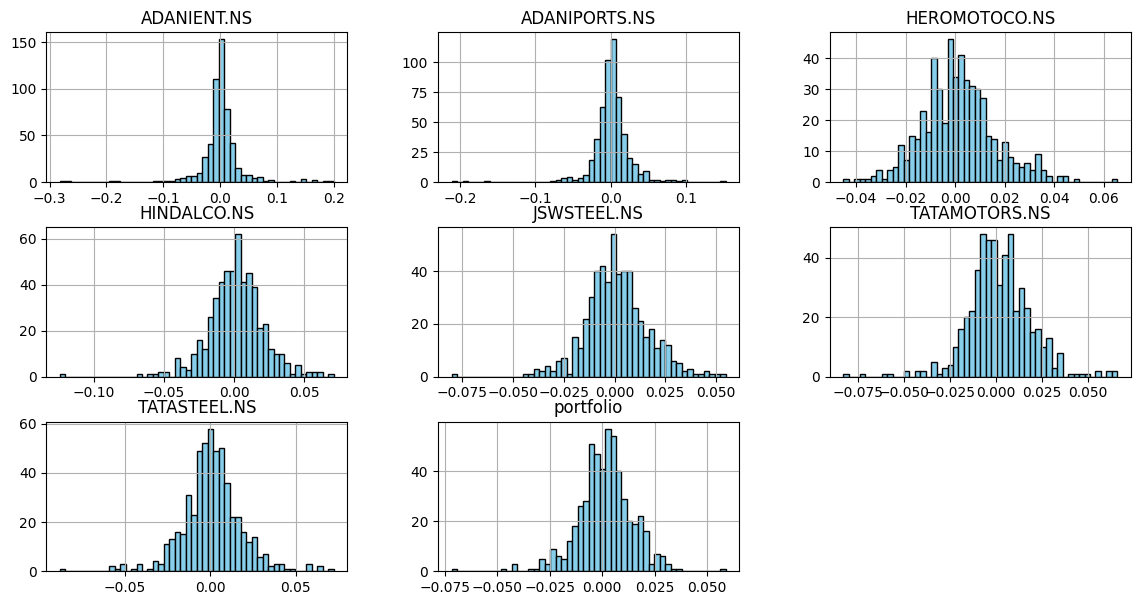

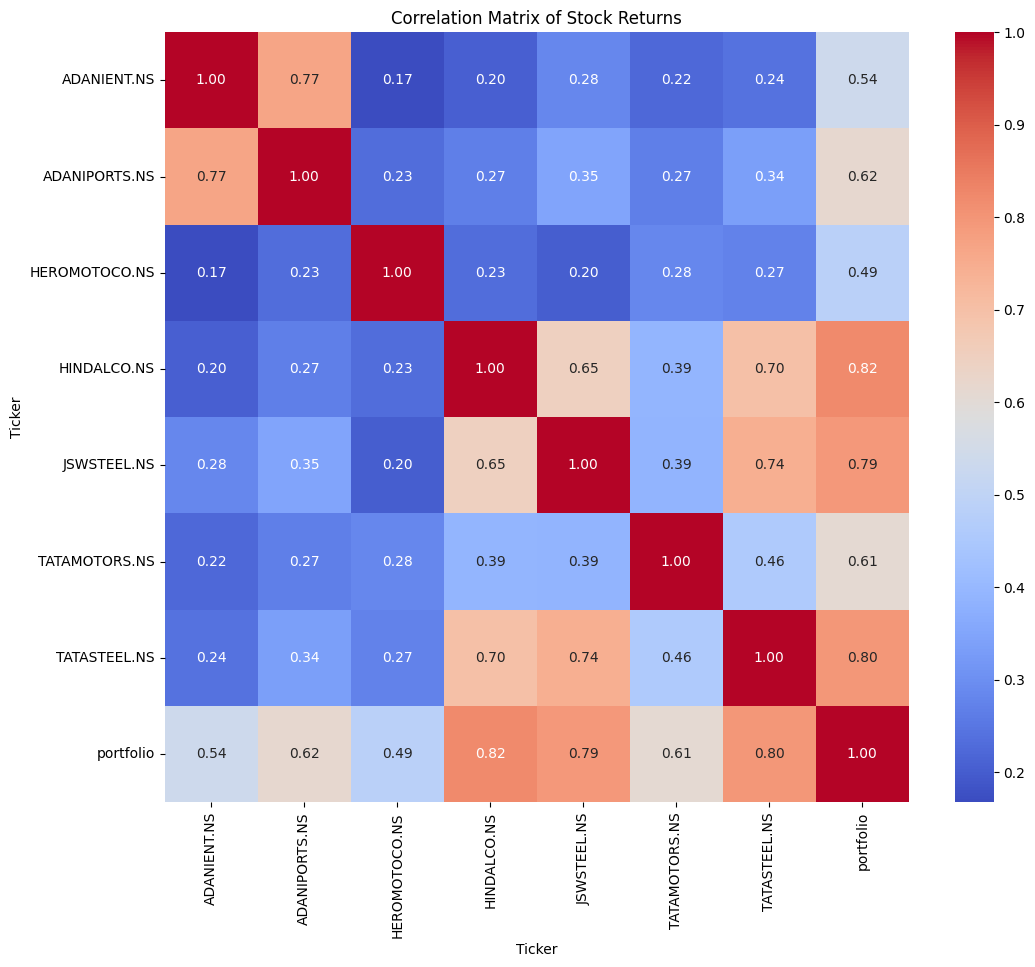

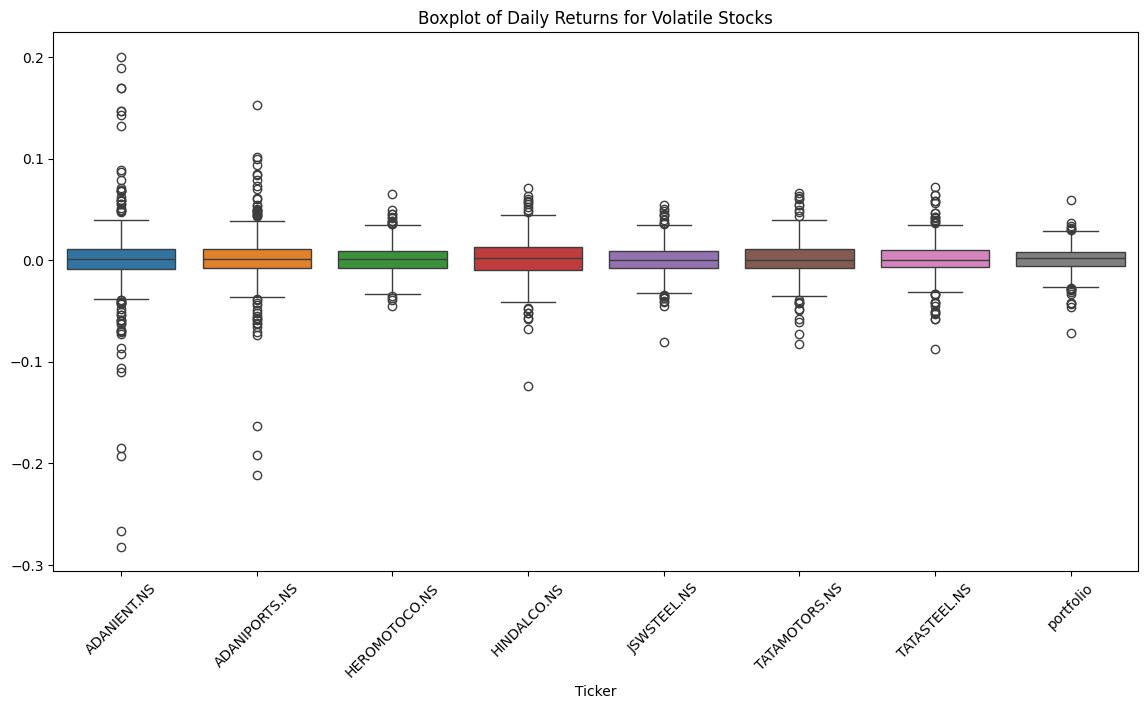

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# EDA: Returns distribution
returns.hist(figsize=(14, 7), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Daily Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# EDA: Correlation Matrix
plt.figure(figsize=(12, 10))
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stock Returns')
plt.show()

# EDA: Boxplots for return distributions
plt.figure(figsize=(14, 7))
sns.boxplot(data=returns)
plt.title('Boxplot of Daily Returns for Volatile Stocks')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


Columns in returns: Index(['ADANIENT.NS', 'ADANIPORTS.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS',
       'JSWSTEEL.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'portfolio'],
      dtype='object', name='Ticker')
Returns shape: (537, 8)
Weights shape: (8,)


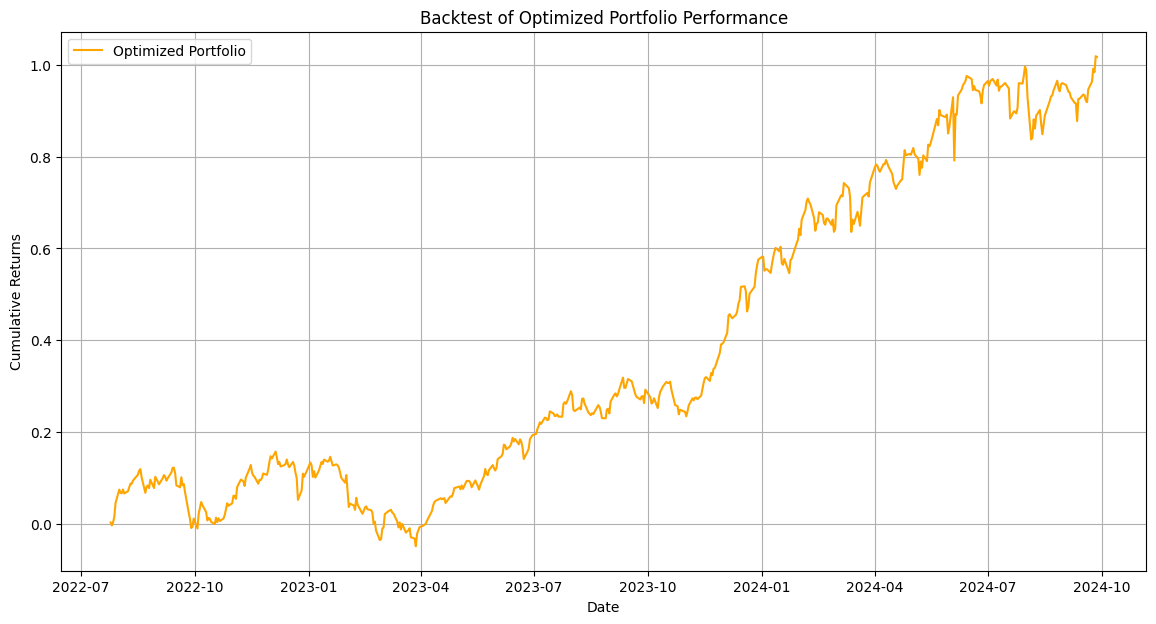

In [21]:
# Assuming this is your combined list of stocks
# Check what stocks are in your returns DataFrame
print("Columns in returns:", returns.columns)

# Generate weights for all stocks in the returns DataFrame
weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)  # Normalize to sum to 1

# Now run the backtest with the updated weights
cumulative_returns = backtest_portfolio(returns, weights)

# Plot the backtest results
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Optimized Portfolio', color='orange')
plt.title('Backtest of Optimized Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
